# AGAMA satellite infall simulation

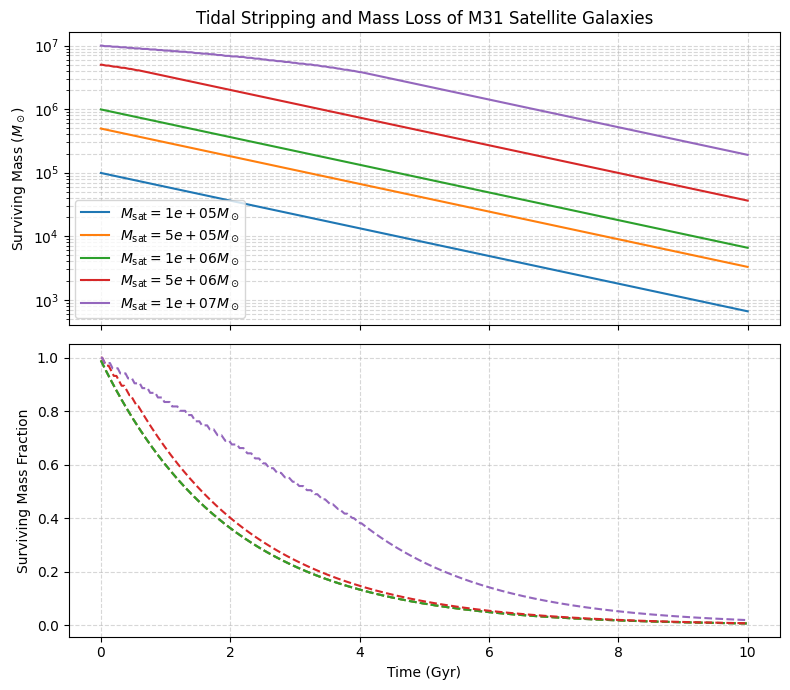

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import agama

# Define NFW halo potential for M31-like galaxy
halo = agama.Potential(type="NFW", mass=1.2e12, scaleRadius=20.0) # 

# Simulation parameters
n_steps = 500
t_end = 10.0  # Gyr
R_half_fixed = 0.5  # kpc, fixed half-light radius

# Define masses to test
masses = [1e5, 5e5, 1e6, 5e6, 1e7]
results = {}

# Time array
time_arr = np.linspace(0, t_end, n_steps)

# Run simulation
for M_sat in masses:
    M_init = M_sat  # Save original mass for labeling
    init_cond = [[40, 0, 0, 0, 90, 0]]  # [x, y, z, vx, vy, vz]
    traj = agama.orbit(potential=halo, ic=init_cond, time=t_end, trajsize=n_steps)
    times, traj_array = traj[0]

    tidal_r = []
    survived_mass = []

    for i in range(n_steps):
        x, y, z = traj_array[i, :3]
        R = np.sqrt(x**2 + y**2 + z**2)
        M_enc = halo.enclosedMass(R)
        r_t = R * (M_sat / (3 * M_enc))**(1/3)
        tidal_r.append(r_t)

        if r_t < R_half_fixed:
            M_sat *= 0.99  # lose 1% per step when disrupted
        survived_mass.append(M_sat)

    results[f"{int(M_init):.0e}"] = {
        "mass": np.array(survived_mass),
        "mass_frac": np.array(survived_mass) / M_init,
        "time": times
    }

# Plotting: two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

for label, data in results.items():
    ax1.plot(data["time"], data["mass"], label=f"$M_{{\\rm sat}} = {label} M_\\odot$")
    ax2.plot(data["time"], data["mass_frac"], linestyle="--")

ax1.set_ylabel("Surviving Mass ($M_\\odot$)")
ax1.set_yscale("log")
ax1.set_title("Tidal Stripping and Mass Loss of M31 Satellite Galaxies")
ax1.grid(True, which="both", ls="--", alpha=0.5)
ax1.legend()

ax2.set_xlabel("Time (Gyr)")
ax2.set_ylabel("Surviving Mass Fraction")
ax2.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()
